# Train Clamer Model with Pre-setting Vocab

In [1]:
# change to the directory of the script
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.clamer import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
d_model = 128
head = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 10

In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# load model
model = GptCovd(d_model=d_model, charlen=charlen, device=device, head=head).to(device, non_blocking=True)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
# sched = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.5)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))  #  打印参数

total parameters: 1.34M


In [8]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        # ignore the first two tokens becauese thay are condition tokens
        output = model(zeo, syn, tgt_input)
        output = output[:, 2:, :].to(device, non_blocking=True).contiguous()
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [9]:

def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output = model(zeo, syn, tgt_input)
            output = output[:, 2:, :].to(device, non_blocking=True).contiguous()
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_Clamer_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_Clamer_model.pth')

100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 0, train loss: 1.2225, train acc: 0.6129


100%|██████████| 68/68 [00:07<00:00,  9.25it/s]


epoch: 0 test loss: 0.8221, test acc: 0.7153


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 1, train loss: 0.7407, train acc: 0.7385


100%|██████████| 68/68 [00:07<00:00,  9.20it/s]


epoch: 1 test loss: 0.6732, test acc: 0.7593


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 2, train loss: 0.6021, train acc: 0.7830


100%|██████████| 68/68 [00:07<00:00,  9.24it/s]


epoch: 2 test loss: 0.5322, test acc: 0.8089


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 3, train loss: 0.5226, train acc: 0.8094


100%|██████████| 68/68 [00:07<00:00,  9.21it/s]


epoch: 3 test loss: 0.4592, test acc: 0.8332


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 4, train loss: 0.4814, train acc: 0.8225


100%|██████████| 68/68 [00:07<00:00,  9.22it/s]


epoch: 4 test loss: 0.4233, test acc: 0.8441


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 5, train loss: 0.4374, train acc: 0.8371


100%|██████████| 68/68 [00:07<00:00,  9.25it/s]


epoch: 5 test loss: 0.3944, test acc: 0.8526


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 6, train loss: 0.4104, train acc: 0.8459


100%|██████████| 68/68 [00:07<00:00,  9.21it/s]


epoch: 6 test loss: 0.3696, test acc: 0.8619


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 7, train loss: 0.3917, train acc: 0.8518


100%|██████████| 68/68 [00:07<00:00,  9.25it/s]


epoch: 7 test loss: 0.3462, test acc: 0.8692


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 8, train loss: 0.3707, train acc: 0.8590


100%|██████████| 68/68 [00:07<00:00,  9.18it/s]


epoch: 8 test loss: 0.3308, test acc: 0.8742


100%|██████████| 284/284 [01:14<00:00,  3.83it/s]


epoch: 9, train loss: 0.3561, train acc: 0.8637


100%|██████████| 68/68 [00:07<00:00,  9.25it/s]

epoch: 9 test loss: 0.3182, test acc: 0.8780


In [11]:
def generate_clamer(model, start_sequence, zeo, syn, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (CLAMER): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        zeo (torch.Tensor): The zeolite condition tensor.
        syn (torch.Tensor): The synthesis condition tensor.
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device
    # expand generated_sequences to the max_length with padding tokens
    padding = torch.full((batch_size, max_length - generated_sequences.size(1)), PAD, dtype=torch.long).to(device)
    generated_sequences_input = torch.cat([generated_sequences, padding], dim=1)[:,:-1].to(device)
    
    with torch.no_grad():
        # Forward pass through the
        for current_len in range(max_length - start_sequence.size(1)):
            
            # Forward pass through the model
            logits = model(zeo, syn, generated_sequences_input)
            # Extract the logits for the last time step
            next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

            # Apply temperature scaling
            next_token_logits = next_token_logits / temperature

            # Apply top-k filtering
            if top_k > 0:
                top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
                mask = torch.full_like(next_token_logits, float('-inf'))
                mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
                next_token_logits = mask

            # Convert logits to probabilities
            next_token_probs = F.softmax(next_token_logits, dim=-1)

            # Sample from the probability distribution
            next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
            
            # Get the most likely next token
            # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            # Append the generated token to the sequence
            generated_sequences = torch.cat([generated_sequences, next_token], dim=1)
            # update the input sequence for the next iteration
            generated_sequences_input[:, current_len] = next_token.squeeze(1)

            # Check if all sequences have reached the end token
            if all(next_token[i].item() == EOS for i in range(batch_size)):
                break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles

In [12]:
def sample_clamer(temp, model, sample_dataloader, device, vocab):
    '''ArithmeticError
    Generate SMILES strings using the trained GPT model with sampling.
    
    Args:
        temp (float): The temperature parameter for sampling.
        model (CLAMER): The pre-trained GPT model for token generation.
        sample_dataloader (DataLoader): The data loader for the SMILES dataset.
        device (torch.device): The device on which to run the generation.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
    
    Returns:
        List[float]: A list of negative log-likelihoods for the generated SMILES strings.
        List[str]: A list of generated SMILES strings.
    '''
    sample_nll_total = []
    smiles_gen_total = []
    with torch.no_grad():
        for batch_idx, (zeo, syn, tgt) in enumerate(tqdm(sample_dataloader)):
            # Generate the target sequence for the model
            target = [SOS] + [PAD] * 218
            tgt_seq = torch.LongTensor(target).unsqueeze(0).expand(zeo.size(0), len(target)).to(device)
            batch_size = zeo.size(0)
            # Move input tensors to the device
            zeo, syn = zeo.to(device), syn.to(device)
            smiles_gen = [[''] * batch_size][0]
            sample_nll = [0] * batch_size
            finished = np.array([False] * batch_size, dtype=object)
            end_char = '<eos>'
            for i in range(218):
                net_out = model(zeo, syn, tgt_seq)[:, i + 2, :]
                o = F.softmax(net_out, dim=-1).cpu().detach().numpy()
                # sample temp
                if temp != 0:
                    temp = abs(temp)  # No negative values
                    next_char_probs = np.log(o) / temp
                    next_char_probs = np.exp(next_char_probs)
                    next_char_probs = next_char_probs.astype(float)
                    next_char_probs = (next_char_probs.T / (next_char_probs.sum(axis=1))).T
                    sampleidc = torch.tensor(
                        [np.random.multinomial(1, next_char_prob, 1).argmax() for next_char_prob in
                            next_char_probs])
                else:
                    sampleidc = torch.tensor(np.argmax(o, axis=1))

                samplechars = [vocab.itos[idx] for idx in sampleidc.numpy()]

                for idx, samplechar in enumerate(samplechars):
                    if not finished[idx]:
                        if samplechar != end_char:
                            # Append the SMILES with the next character
                            smiles_gen[idx] += samplechar
                            tgt_seq[:, i + 1] = sampleidc.to(device)
                            # Calculate negative log likelihood for the selected character
                            sample_nll[idx] -= np.log(o[idx][sampleidc[idx]])
                        else:
                            finished[idx] = True
                            # print("SMILES has finished at %i" %i)
                # If all SMILES are finished, i.e. the end_char "<eos>" has been generated, stop the generation
            if finished.sum() == len(finished):
                sample_nll_total += sample_nll
                smiles_gen_total += smiles_gen
                    
    return sample_nll_total, smiles_gen_total

In [13]:
# generate the smiles for the test dataset
sample_nll_total, generated_smiles = sample_clamer(temp=0.7, model=model, sample_dataloader=test_dataloader, device=device, vocab=vocab)
target_smiles = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    tgt = tgt.to(device)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smiles.extend(tgt_smiles)
print('the total num of target smiles is :', len(target_smiles))

100%|██████████| 68/68 [00:24<00:00,  2.79it/s]

the total num of target smiles is : 34804


In [14]:
print('the generated smiles are :', generated_smiles[1:3])
print('the target smiles are :', target_smiles[1:3])

the generated smiles are : ['c1(C)[n+](Cc2ccc(C[n+]3c(C)n(C)cc3)cc2)ccn1C', 'C1CC2C3C4C(C(C)(C=C3)C1C)C[N+](C)(C)C4']
the target smiles are : ['c1(C)[n+](Cc2ccccc2C[n+]2c(C)n(C)cc2)ccn1C', 'C(c1ccccc1C[n+]1ccn(C)c1C)[n+]1ccn(C)c1C']


In [15]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smiles))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smiles))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smiles), generated_smiles))
print('FCD score:', FCD_score(target_smiles, generated_smiles))

[13:24:18] SMILES Parse Error: unclosed ring for input: 'C1CC2C3C4C(C(C)(C=C3)C1C)C[N+](C)(C)C4'
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 0 2 3 12 13
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 16 17 18
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 29
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 0 9 10 19 20
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6 7 8
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 0 18 19
[13:24:18] SMILES Parse Error: unclosed ring for input: 'C1CCC[N+]12Cc1ccccc1C[N+]1(C)CCCC1'
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 19
[13:24:18] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 28
[13:24:18] SMILES Parse Error: unclosed ring for input: 'C1CCC2CCCCC2[N+]12CCCCC1'
[13:24:18] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C4C3C[N+](C)(C)CC43)C1C2'
[13:24:18] SMILES Parse Error: unclosed ring for in

Validity rate: 0.9232559475922307
Uniqueness rate: 0.45845305137340536
Novelty rate: 0.7919278014539985
Reconstructability rate: 0.2080721985460015
Novelty rate: 0.7919278014539985


[13:24:24] SMILES Parse Error: unclosed ring for input: 'C1CC2C3C4C(C(C)(C=C3)C1C)C[N+](C)(C)C4'
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 0 2 3 12 13
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 16 17 18
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 29
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 0 9 10 19 20
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 1 2 6 7 8
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 0 18 19
[13:24:24] SMILES Parse Error: unclosed ring for input: 'C1CCC[N+]12Cc1ccccc1C[N+]1(C)CCCC1'
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 19
[13:24:24] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 28
[13:24:24] SMILES Parse Error: unclosed ring for input: 'C1CCC2CCCCC2[N+]12CCCCC1'
[13:24:24] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C4C3C[N+](C)(C)CC43)C1C2'
[13:24:24] SMILES Parse Error: unclosed ring for in

IntDiv: 0.8814035597690215


[13:29:41] SMILES Parse Error: unclosed ring for input: 'C1CC2C3C4C(C(C)(C=C3)C1C)C[N+](C)(C)C4'
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 0 2 3 12 13
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 16 17 18
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 29
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 0 9 10 19 20
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 1 2 6 7 8
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 0 18 19
[13:29:41] SMILES Parse Error: unclosed ring for input: 'C1CCC[N+]12Cc1ccccc1C[N+]1(C)CCCC1'
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 19
[13:29:41] Can't kekulize mol.  Unkekulized atoms: 0 8 9 10 19 20 28
[13:29:41] SMILES Parse Error: unclosed ring for input: 'C1CCC2CCCCC2[N+]12CCCCC1'
[13:29:41] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C4C3C[N+](C)(C)CC43)C1C2'
[13:29:41] SMILES Parse Error: unclosed ring for in

FCD score: 0.2920758599920248


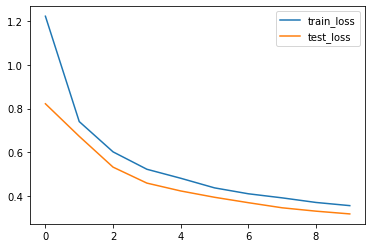

In [16]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'Clamer')